In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical

In [30]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.layers import Convolution2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from zipfile import ZipFile
from keras.applications import vgg16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [31]:
from sklearn.metrics import classification_report

Check tf version, if not working, change to 2.12.0

In [32]:
print(tf.__version__)

2.15.0


Visualise random images and also analyse the dimensions

C:\Users\smitg\AppData\Local\Temp\ipykernel_15264\4234107625.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


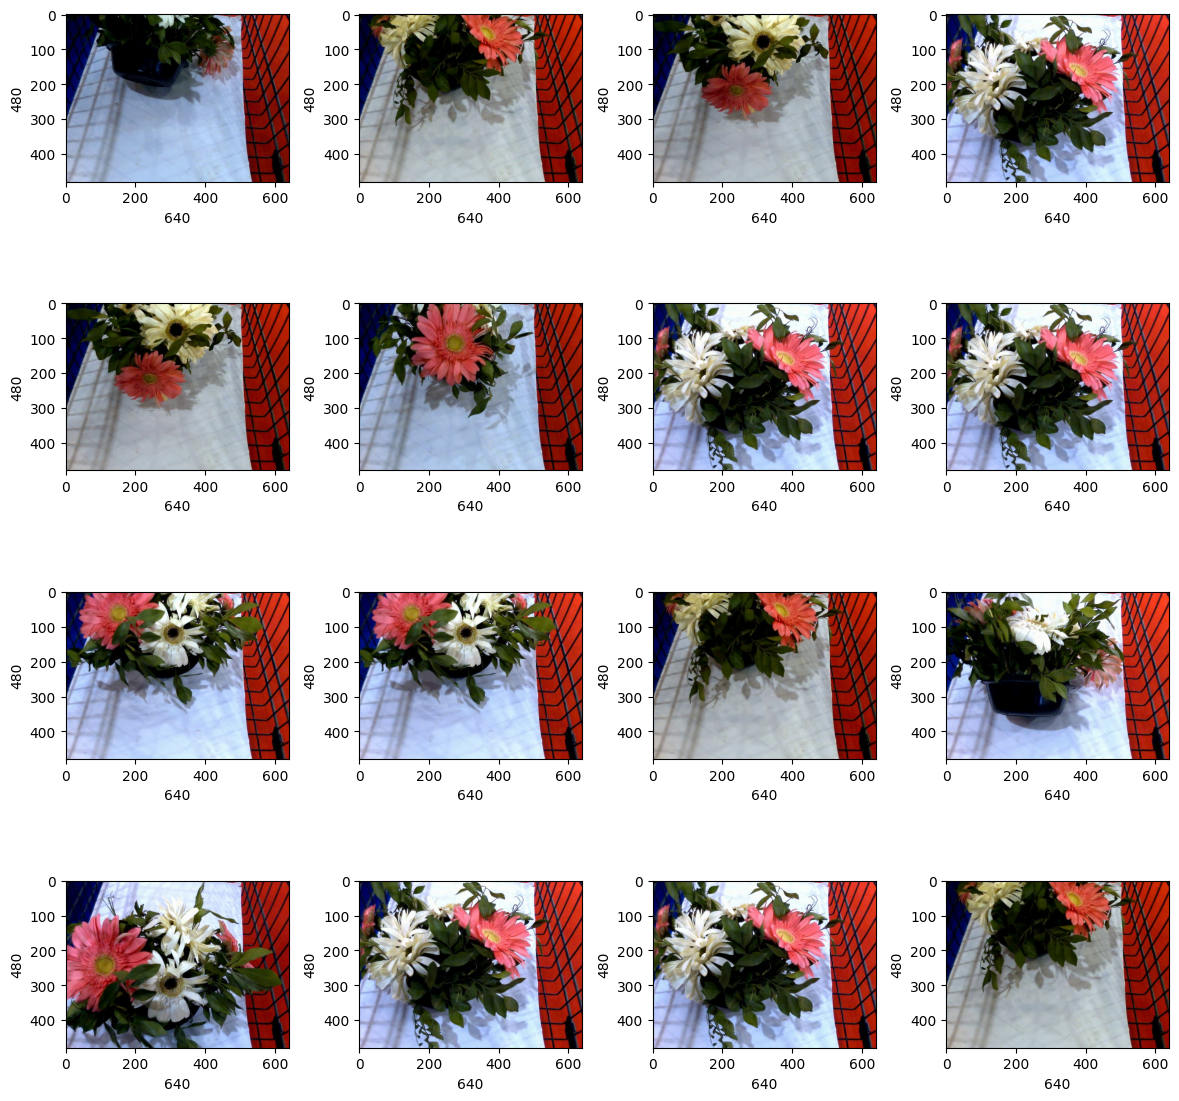

In [33]:
plt.figure(figsize = (12,12))
path = "../dataset_v10/train/FLOWERPOT/"
for i in range(1,17):
  plt.subplot(4,4,i)
  plt.tight_layout()
  rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize = 10)
  plt.ylabel(rand_img.shape[0], fontsize = 10)

Convert to numpy array


In [34]:
def convert_image_to_array(image_dir):
  try:
    image = cv2.imread(image_dir)
    if image is not None:
      image = cv2.resize(image, (224,224))
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print(f"Error : {e}")
    return None

In [35]:
dir_train = "../dataset_v10/train/"
dir_test = "../dataset_v10/test/"

image_list_train, label_list_train = [], []
image_list_test, label_list_test = [], []

all_labels = ["FLOWERPOT", "GLUEGUN", "MAGGIE", "NOTHING", "PANIPURI MASALA", "POMOGRANATE"]

binary_labels = [0, 1, 2, 3, 4, 5]

temp = -1

for directory in all_labels:
    plant_image_list = listdir(f"{dir_train}/{directory}")
    temp += 1
    for files in plant_image_list:
      image_path = f"{dir_train}/{directory}/{files}"
      image_list_train.append(convert_image_to_array(image_path))
      label_list_train.append(binary_labels[temp])

temp = -1

for directory in all_labels:
    plant_image_list = listdir(f"{dir_test}/{directory}")
    temp += 1
    for files in plant_image_list:
      image_path = f"{dir_test}/{directory}/{files}"
      image_list_test.append(convert_image_to_array(image_path))
      label_list_test.append(binary_labels[temp])

split train set into validation and create test set as well

In [36]:
x_train, x_val, y_train, y_val = train_test_split(image_list_train, label_list_train, test_size = 0.2)
x_test = image_list_test
y_test = label_list_test

normalize


In [37]:
x_train = np.array(x_train, dtype = np.float16) / 255.0
x_val = np.array(x_val, dtype = np.float16) / 255.0
x_test = np.array(x_test, dtype = np.float16) / 255.0
x_train = x_train.reshape(-1, 224, 224, 3)
x_val = x_val.reshape(-1, 224, 224, 3)
x_test = x_test.reshape(-1, 224, 224, 3)

one-hot encode target variable

In [38]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

download vgg and initalise

In [39]:
img_rows, img_cols = 224, 224

vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False, # making sure not to take last layer
                 input_shape = (img_rows, img_cols, 3))

# dont keep layers of pretrained model as trainable =
for layer in vgg.layers:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

create extra layers

In [40]:
def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dense(96,activation='relu')(top_model)
    top_model = Dense(64,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

join model

In [41]:
num_classes = 6
new_FC_Head2 = lw(vgg, num_classes)
new_model2 = Model(inputs = vgg.input, outputs = new_FC_Head2)
print(new_model2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

compile and train

In [42]:
new_model2.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = new_model2.fit(x_train,y_train,
                    epochs=5,
                    validation_data=(x_val,y_val),
                    verbose = 1,
                    initial_epoch=0)


Epoch 1/5


192/192 [==============================] - 377s 2s/step - loss: 0.3029 - accuracy: 0.9103 - val_loss: 0.0050 - val_accuracy: 0.9987
Epoch 2/5
192/192 [==============================] - 374s 2s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.3804e-04 - val_accuracy: 1.0000
Epoch 3/5
192/192 [==============================] - 393s 2s/step - loss: 3.1901e-04 - accuracy: 1.0000 - val_loss: 2.7279e-04 - val_accuracy: 1.0000
Epoch 4/5
192/192 [==============================] - 383s 2s/step - loss: 1.5360e-04 - accuracy: 1.0000 - val_loss: 1.0707e-04 - val_accuracy: 1.0000
Epoch 5/5
192/192 [==============================] - 391s 2s/step - loss: 8.9339e-05 - accuracy: 1.0000 - val_loss: 6.7354e-05 - val_accuracy: 1.0000


extract accuracy and loss

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plot accuracy for training and validation

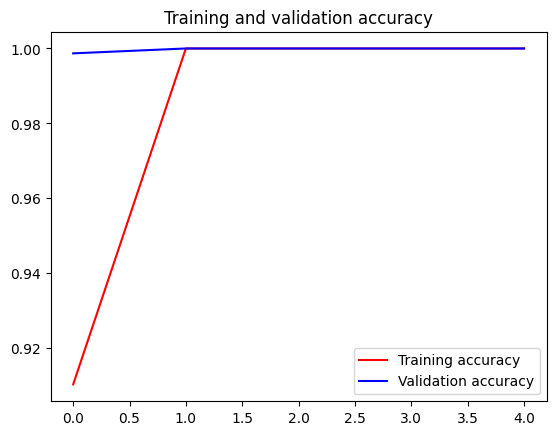

<Figure size 640x480 with 0 Axes>

In [44]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plot loss for training and validation

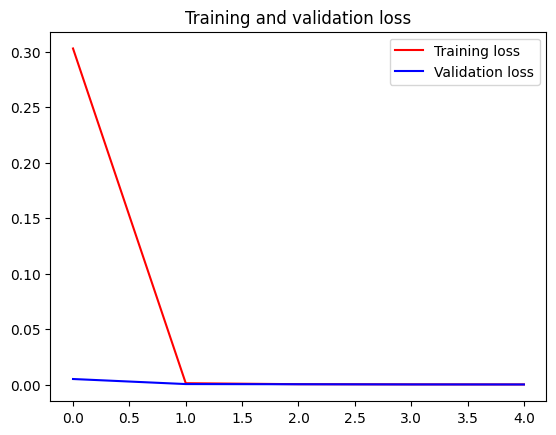

<Figure size 640x480 with 0 Axes>

In [45]:
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

print test accuracy

In [46]:
scores = new_model2.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

61/61 [==============================] - 99s 2s/step - loss: 1.7355e-04 - accuracy: 1.0000
Test Accuracy: 100.0


get predictions

In [47]:
y_pred = new_model2.predict(x_test)

61/61 [==============================] - 109s 2s/step


print true labels - predictions

In [48]:
# def denormalize(image):
#     mean = 0.5
#     std = 0.5
#     return (image * std) + mean

# # Choose a random subset of images to visualize
# num_images_to_visualize = 20
# random_indices = np.random.choice(len(x_train), num_images_to_visualize, replace=False)

# # Plot the images
# plt.figure(figsize=(15, 3))

# for i, idx in enumerate(random_indices, 1):
#     plt.subplot(1, num_images_to_visualize, i)
    
#     # Convert the image dtype to uint8
#     image = (denormalize(x_train[idx]) * 255).astype(np.uint8)
    
#     plt.imshow(image)
#     plt.title(f'Class: {y_train[idx]}')
#     plt.axis('off')

# plt.show()

In [49]:
for i in range(len(y_pred)):
  print(all_labels[np.argmax(y_test[i])], "-", all_labels[np.argmax(y_pred[i])])

FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT - FLOWERPOT
FLOWERPOT 

In [50]:
new_model2.save_weights("../saved_models/vibrant_model_weights.h5")

In [51]:
new_model2.save("../saved_models/vibrant_model.keras")